In [1]:
import math

class Heuristics:
    @staticmethod
    def euclidean_distance(pos1, pos2):
        x1, y1 = pos1
        x2, y2 = pos2
        return math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

    @staticmethod
    def manhattan_distance(pos1, pos2):
        x1, y1 = pos1
        x2, y2 = pos2
        return abs(x1 - x2) + abs(y1 - y2)
    
    @staticmethod
    def chebyshev_distance(pos1, pos2):
        # Calculate the Chebyshev distance heuristic from 'pos' to the goal.
        x1, y1 = pos1
        x2, y2 = pos2
        dx = abs(x1 - x2)
        dy = abs(y1 - y2)
        return max(dx, dy)
    
    @staticmethod
    def octile_distance(pos1, pos2):
        x1, y1 = pos1
        x2, y2 = pos2
        dx = abs(x1 - x2)
        dy = abs(y1 - y2)
        return dx + dy + (math.sqrt(2) - 2) * min(dx, dy)
    
    @staticmethod
    def zero_heuristic(pos1, pos2):
        # Zero Heuristic always returns zero, effectively turning A* into Dijkstra's algorithm.
        return 0


In [2]:
class Game:
    def __init__(self, maze):
        self.maze = maze

    def get_neighbors(self, pos):
        # Get neighboring positions that are open (0) in the maze.
        neighbors = []
        x, y = pos
        for dx, dy in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
            new_x, new_y = x + dx, y + dy
            if (
                0 <= new_x < len(self.maze)
                and 0 <= new_y < len(self.maze[0])
                and self.maze[new_x][new_y] == 0
            ):
                neighbors.append((new_x, new_y))
        return neighbors

    def is_goal_state(self, state):
        return state == self.goal

In [3]:
import heapq
import time
import random

class Agent:
    def __init__(self, game, start, goal, heuristic_name):
        self.game = game
        self.start = start
        self.goal = goal
        self.heuristic_name = heuristic_name

    def heuristic(self, pos):
        # Choose and call a heuristic function from the Heuristics class.
        
        if self.heuristic_name == "zero":
            return Heuristics.zero_heuristic(pos, self.goal)
        elif self.heuristic_name == "euclidean":
            return Heuristics.euclidean_distance(pos, self.goal)
        elif self.heuristic_name == "manhattan":
            return Heuristics.manhattan_distance(pos, self.goal)
        elif self.heuristic_name == "chebyshev":
            return Heuristics.chebyshev_distance(pos, self.goal)
        elif self.heuristic_name == "octile":
            return Heuristics.octile_distance(pos, self.goal)
        
        
    def find_path_A_star(self):
        # Implementation of the A* search algorithm starts here.
        start_time = time.time()
        # Priority queue for open nodes.
        open_set = [] 
        heapq.heappush(open_set, (0, self.start)) 
        # Dictionary to track where each node came from.
        came_from = {} 
        # Dictionary for storing the actual cost from start to each node.
        g_score = {pos: float('inf') for row in self.game.maze for pos in row} 
        g_score[self.start] = 0  
        # Dictionary for storing the total estimated cost from start to goal through each node.
        f_score = {pos: float('inf') for row in self.game.maze for pos in row} 
        # The estimated cost to reach the goal from the start node.
        f_score[self.start] = self.heuristic(self.start) 
        # Variable to track the maximum size of the open set during the search.
        max_open_set_size = 1
        # Variable to count the number of nodes explored during the search. 
        nodes_explored = 0 

        while open_set:
            max_open_set_size = max(max_open_set_size, len(open_set)) 
            # Get the node with the lowest f-score.
            _, current = heapq.heappop(open_set) 
            nodes_explored += 1 

            if current == self.goal:
                # Goal reached, calculate execution time and return the path and statistics.
                path = self.reconstruct_path(came_from, current)
                path_length = len(path)  
                end_time = time.time()
                execution_time = end_time - start_time
                return path, nodes_explored, max_open_set_size, execution_time, path_length 

            for neighbor in self.game.get_neighbors(current):
                # Calculate tentative g-score, check if a better path is found, and update accordingly.
                tentative_g_score = g_score[current] + 1
                if tentative_g_score < g_score.get(neighbor, float('inf')):
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = g_score[neighbor] + self.heuristic(neighbor)
                    heapq.heappush(open_set, (f_score[neighbor], neighbor))
        # If the open set is exhausted and no path is found, calculate execution time and return None with statistics.
        end_time = time.time()
        execution_time = end_time - start_time
        return None, nodes_explored, max_open_set_size, execution_time, 0


    # def find_path_best_first_search(self, random_factor=0.05):
    def find_path_best_first_search(self, random_factor=0.4):
        start_time = time.time()
        open_set = []  # Priority queue for open nodes.
        heapq.heappush(open_set, (0, self.start))  # Add the start node to the open set.
        came_from = {}  # Dictionary to track where each node came from.
        max_open_set_size = 1  # Variable to track the maximum size of the open set during the search.
        nodes_explored = 0  # Variable to count the number of nodes explored during the search.
        visited = set()  # Set to track visited nodes.

        while open_set:
            max_open_set_size = max(max_open_set_size, len(open_set))  # Update the maximum open set size.
            # Get the node with the lowest f-score.
            if random.random() < random_factor:
                # Occasionally, choose a random node instead of the one with the lowest f-score.
                _, current = random.choice(open_set)
            else:
                # Get the node with the lowest f-score.
                _, current = heapq.heappop(open_set)
            nodes_explored += 1  # Increment the nodes explored count.

            if current == self.goal:
                # Goal reached, calculate execution time and return the path and statistics.
                path = self.reconstruct_path(came_from, current)
                path_length = len(path)  # Calculate path length
                end_time = time.time()
                execution_time = end_time - start_time
                return path, nodes_explored, max_open_set_size, execution_time, path_length

            visited.add(current)  # Mark the current node as visited.

            for neighbor in self.game.get_neighbors(current):
                if neighbor not in visited:
                    # Calculate the heuristic value for the neighbor.
                    neighbor_heuristic = self.heuristic(neighbor)
                    # Add the neighbor to the open set with the heuristic value as priority.
                    heapq.heappush(open_set, (neighbor_heuristic, neighbor))
                    # Update the came_from dictionary to track the path.
                    came_from[neighbor] = current

        # If the open set is exhausted and no path is found, calculate execution time and return None with statistics.
        end_time = time.time()
        execution_time = end_time - start_time
        return None, nodes_explored, max_open_set_size, execution_time, 0




    def reconstruct_path(self, came_from, current):
        # Initialize the path list with the current (goal) node.
        path = [current]
        # Backtrack from the goal node to the start node using the 'came_from' dictionary.
        while current in came_from:
            current = came_from[current]
            path.append(current)

        # Reverse the path to obtain the correct order from start to goal.
        path.reverse()
        return path
    



In [4]:
# Define the maze as a 2D grid (1 represents a wall, 0 represents an open path).
mazes = [[
    [0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
    [0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1],
    [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1],
    [1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1],
    [0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1],
    [0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
    [0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1],
    [0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0],
    [1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
    [1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1],
    [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0],
    [0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1],
    [0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
    [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0]
],
[
    [0, 0, 1, 1, 1, 1, 1, 1],
    [1, 0, 0, 0, 1, 0, 0, 1],
    [1, 1, 1, 0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 1, 0, 1],
    [1, 1, 1, 1, 1, 0, 0, 0],
    [1, 0, 0, 1, 0, 0, 1, 1],
    [1, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 0]
]
]

# Define the start and goal positions.
starts = [(0, 0),(0,0)]
goals = [(19, 19),(7,7)]

execution_times_euclidean_A_star = []
execution_times_manhattan_A_star = []
execution_times_chebyshev_A_star = []
execution_times_octile_A_star = []
execution_times_zero_A_star = []

node_explored_euclidean_A_star = []
node_explored_manhattan_A_star = []
node_explored_chebyshev_A_star = []
node_explored_octile_A_star = []
node_explored_zero_A_star = []

open_sets_euclidean_A_star = []
open_sets_manhattan_A_star = []
open_sets_chebyshev_A_star = []
open_sets_octile_A_star = []
open_sets_zero_A_star = []

path_lengths_euclidean_A_star = []
path_lengths_manhattan_A_star = []
path_lengths_chebyshev_A_star = []
path_lengths_octile_A_star = []
path_lengths_zero_A_star = []

execution_times_euclidean_best_first = []
execution_times_manhattan_best_first = []
execution_times_chebyshev_best_first = []
execution_times_octile_best_first = []
execution_times_zero_best_first = []

node_explored_euclidean_best_first = []
node_explored_manhattan_best_first = []
node_explored_chebyshev_best_first = []
node_explored_octile_best_first = []
node_explored_zero_best_first = []

open_sets_euclidean_best_first = []
open_sets_manhattan_best_first = []
open_sets_chebyshev_best_first = []
open_sets_octile_best_first = []
open_sets_zero_best_first = []

path_lengths_euclidean_best_first = []
path_lengths_manhattan_best_first = []
path_lengths_chebyshev_best_first = []
path_lengths_octile_best_first = []
path_lengths_zero_best_first = []

# Create a game instance.
for maze,start,goal in zip(mazes, starts, goals):
    heuristic_names = ["euclidean", "manhattan", "chebyshev", "octile", "zero"]
    algorithm_names = ["a_star", "best_first"]
    for heuristic_name in heuristic_names:
        for algorithm_name in algorithm_names:
            game = Game(maze)
            # Create an agent and find the path.
            agent = Agent(game, start, goal, heuristic_name)
            # path, nodes_explored, max_open_set_size, execution_time, path_length = agent.find_path_A_star()
            path, nodes_explored, max_open_set_size, execution_time, path_length = agent.find_path_best_first_search()
            
            # Print the path and statistics.
            if heuristic_name == "euclidean" and algorithm_name == "a_star":
                print("A Star Euclidean: ")
                execution_times_euclidean_A_star.append(execution_time)
                node_explored_euclidean_A_star.append(nodes_explored)
                open_sets_euclidean_A_star.append(max_open_set_size)
                path_lengths_euclidean_A_star.append(path_length)

            elif heuristic_name == "euclidean" and algorithm_name == "best_first":
                print("Best First Euclidean: ")
                execution_times_euclidean_best_first.append(execution_time)
                node_explored_euclidean_best_first.append(nodes_explored)
                open_sets_euclidean_best_first.append(max_open_set_size)
                path_lengths_euclidean_best_first.append(path_length)

            elif heuristic_name == "manhattan" and algorithm_name == "a_star":
                print("A Star Manhattan: ")
                execution_times_manhattan_A_star.append(execution_time)
                node_explored_manhattan_A_star.append(nodes_explored)
                open_sets_manhattan_A_star.append(max_open_set_size)
                path_lengths_manhattan_A_star.append(path_length)
            
            elif heuristic_name == "manhattan" and algorithm_name == "best_first":
                print("Best First Manhattan: ")
                execution_times_manhattan_best_first.append(execution_time)
                node_explored_manhattan_best_first.append(nodes_explored)
                open_sets_manhattan_best_first.append(max_open_set_size)
                path_lengths_manhattan_best_first.append(path_length)

            elif heuristic_name == "chebyshev" and algorithm_name == "a_star":
                print("A Star Chebyshev: ")
                execution_times_chebyshev_A_star.append(execution_time)
                node_explored_chebyshev_A_star.append(nodes_explored)
                open_sets_chebyshev_A_star.append(max_open_set_size)
                path_lengths_chebyshev_A_star.append(path_length)

            elif heuristic_name == "chebyshev" and algorithm_name == "best_first":
                print("Best First Chebyshev: ")
                execution_times_chebyshev_best_first.append(execution_time)
                node_explored_chebyshev_best_first.append(nodes_explored)
                open_sets_chebyshev_best_first.append(max_open_set_size)
                path_lengths_chebyshev_best_first.append(path_length)

            elif heuristic_name == "octile" and algorithm_name == "a_star":
                print("A Star Octile: ")
                execution_times_octile_A_star.append(execution_time)
                node_explored_octile_A_star.append(nodes_explored)
                open_sets_octile_A_star.append(max_open_set_size)
                path_lengths_octile_A_star.append(path_length)

            elif heuristic_name == "octile" and algorithm_name == "best_first":
                print("Best First Octile: ")
                execution_times_octile_best_first.append(execution_time)
                node_explored_octile_best_first.append(nodes_explored)
                open_sets_octile_best_first.append(max_open_set_size)
                path_lengths_octile_best_first.append(path_length)


            elif heuristic_name == "zero" and algorithm_name == "a_star":
                print("A Star Zero: ")
                execution_times_zero_A_star.append(execution_time)
                node_explored_zero_A_star.append(nodes_explored)
                open_sets_zero_A_star.append(max_open_set_size)
                path_lengths_zero_A_star.append(path_length)
            
            elif heuristic_name == "zero" and algorithm_name == "best_first":
                print("Best First Zero: ")
                execution_times_zero_best_first.append(execution_time)
                node_explored_zero_best_first.append(nodes_explored)
                open_sets_zero_best_first.append(max_open_set_size)
                path_lengths_zero_best_first.append(path_length)


            if path:
                for pos in path:
                    print(pos)
                print(f"Execution Time: {execution_time:.10f} seconds")
                print(f"Nodes Explored: {nodes_explored}")
                print(f"Max Open Set Size: {max_open_set_size}")
                print(f"Path Length: {path_length}")
            else:
                print("No path found.")


A Star Euclidean: 
(0, 0)
(1, 0)
(2, 0)
(2, 1)
(2, 2)
(3, 2)
(3, 3)
(3, 4)
(2, 4)
(2, 5)
(2, 6)
(2, 7)
(1, 7)
(1, 8)
(1, 9)
(2, 9)
(3, 9)
(4, 9)
(5, 9)
(5, 10)
(5, 11)
(4, 11)
(3, 11)
(3, 12)
(3, 13)
(3, 14)
(3, 15)
(2, 15)
(1, 15)
(1, 16)
(1, 17)
(1, 18)
(2, 18)
(3, 18)
(4, 18)
(5, 18)
(5, 17)
(5, 16)
(5, 15)
(6, 15)
(7, 15)
(8, 15)
(9, 15)
(10, 15)
(11, 15)
(12, 15)
(13, 15)
(14, 15)
(15, 15)
(15, 14)
(16, 14)
(16, 13)
(17, 13)
(18, 13)
(18, 14)
(18, 15)
(18, 16)
(19, 16)
(19, 17)
(19, 18)
(19, 19)
Execution Time: 0.0000000000 seconds
Nodes Explored: 124
Max Open Set Size: 69
Path Length: 61
Best First Euclidean: 
(0, 0)
(1, 0)
(1, 1)
(2, 1)
(2, 2)
(3, 2)
(3, 3)
(3, 4)
(2, 4)
(2, 5)
(2, 6)
(1, 6)
(1, 7)
(1, 8)
(1, 9)
(2, 9)
(3, 9)
(4, 9)
(5, 9)
(5, 10)
(5, 11)
(4, 11)
(3, 11)
(3, 12)
(3, 13)
(3, 14)
(3, 15)
(2, 15)
(1, 15)
(1, 16)
(1, 17)
(1, 18)
(2, 18)
(3, 18)
(4, 18)
(5, 18)
(5, 17)
(5, 16)
(5, 15)
(6, 15)
(7, 15)
(8, 15)
(9, 15)
(10, 15)
(11, 15)
(12, 15)
(13, 15)
(14, 15)
(15, 1

A star: 0.0005126476287841796 and Best-First: 0.0011017799377441406


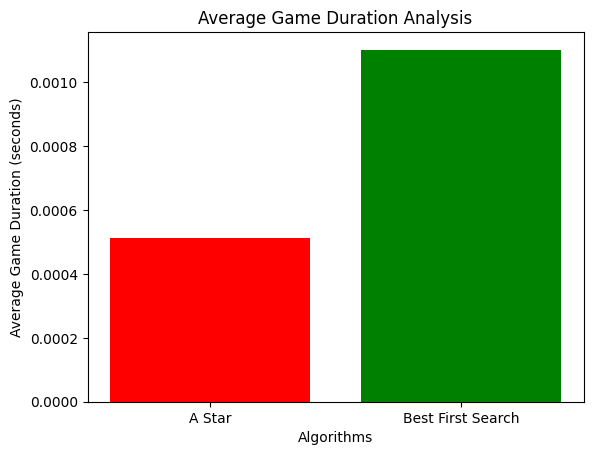

In [5]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt


# Combine all data into one list or array
all_execution_times_A_star = [execution_times_euclidean_A_star, execution_times_manhattan_A_star, execution_times_chebyshev_A_star, execution_times_octile_A_star, execution_times_zero_A_star]  # Add data for other heuristics
all_execution_times_best_first = [execution_times_euclidean_best_first, execution_times_manhattan_best_first, execution_times_chebyshev_best_first, execution_times_octile_best_first, execution_times_zero_best_first]  # Add data for other heuristics

average_of_two_games_A_star = []
average_of_two_games_best_first = []

for i in all_execution_times_A_star:
    average = sum(i)/len(i)
    average_of_two_games_A_star.append(average)

for i in all_execution_times_best_first:
    average = sum(i)/len(i)
    average_of_two_games_best_first.append(average)

a_star_average_duration = sum(average_of_two_games_A_star) / len(average_of_two_games_A_star)
best_first_average_duration = sum(average_of_two_games_best_first) / len(average_of_two_games_best_first)
average_durations = [a_star_average_duration, best_first_average_duration]

algorithm_list = ['A Star', 'Best First Search']
print("A star: "+str(a_star_average_duration)+ " and Best-First: "+ str(best_first_average_duration))
# Create a bar chart
plt.bar(algorithm_list, average_durations, color=['red', 'green'])
plt.xlabel('Algorithms')
plt.ylabel('Average Game Duration (seconds)')
plt.title('Average Game Duration Analysis')

# Display the plot
plt.show()

A star: 143.0 and Best-First: 138.3


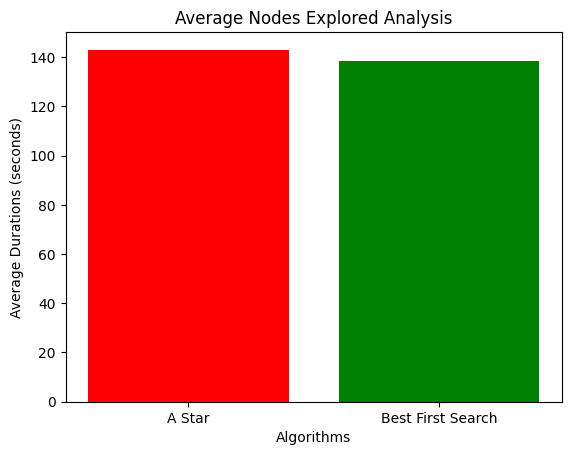

In [6]:
# Combine all data into one list or array
all_nodes_explored_A_star = [node_explored_euclidean_A_star, node_explored_manhattan_A_star, node_explored_chebyshev_A_star, node_explored_octile_A_star, node_explored_zero_A_star]  # Add data for other heuristics
all_nodes_explored_best_first = [node_explored_euclidean_best_first, node_explored_manhattan_best_first, node_explored_chebyshev_best_first, node_explored_octile_best_first, node_explored_zero_best_first]  # Add data for other heuristics

average_of_two_games_A_star = []
average_of_two_games_best_first = []

for i in all_nodes_explored_A_star:
    average = sum(i)/len(i)
    average_of_two_games_A_star.append(average)

for i in all_nodes_explored_best_first:
    average = sum(i)/len(i)
    average_of_two_games_best_first.append(average)

a_star_nodes_explored = sum(average_of_two_games_A_star) / len(average_of_two_games_A_star)
best_first_nodes_explored = sum(average_of_two_games_best_first) / len(average_of_two_games_best_first)

nodes_exploreds = [a_star_nodes_explored, best_first_nodes_explored]

algorithm_list = ['A Star', 'Best First Search']
print("A star: "+str(a_star_nodes_explored)+ " and Best-First: "+ str(best_first_nodes_explored))
# Create a bar chart
plt.bar(algorithm_list, nodes_exploreds, color=['red', 'green'])
plt.xlabel('Algorithms')
plt.ylabel('Average Durations (seconds)')
plt.title('Average Nodes Explored Analysis')

# Display the plot
plt.show()

A star: 38.2 and Best-First: 36.2


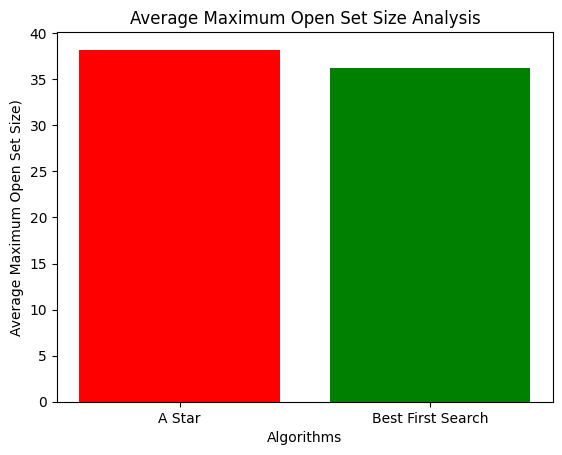

In [7]:
# Combine all data into one list or array
all_open_sets_A_star = [open_sets_euclidean_A_star, open_sets_manhattan_A_star, open_sets_chebyshev_A_star, open_sets_octile_A_star, open_sets_zero_A_star]  # Add data for other heuristics
all_open_sets_best_first = [open_sets_euclidean_best_first, open_sets_manhattan_best_first, open_sets_chebyshev_best_first, open_sets_octile_best_first, open_sets_zero_best_first]  # Add data for other heuristics

average_of_two_games_A_star = []
average_of_two_games_best_first = []

for i in all_open_sets_A_star:
    average = sum(i)/len(i)
    average_of_two_games_A_star.append(average)

for i in all_open_sets_best_first:
    average = sum(i)/len(i)
    average_of_two_games_best_first.append(average)

a_star_open_sets = sum(average_of_two_games_A_star) / len(average_of_two_games_A_star)
best_first_open_sets = sum(average_of_two_games_best_first) / len(average_of_two_games_best_first)

open_setss = [a_star_open_sets, best_first_open_sets]

algorithm_list = ['A Star', 'Best First Search']
print("A star: "+str(a_star_open_sets)+ " and Best-First: "+ str(best_first_open_sets))
# Create a bar chart
plt.bar(algorithm_list, open_setss, color=['red', 'green'])
plt.xlabel('Algorithms')
plt.ylabel('Average Maximum Open Set Size)')
plt.title('Average Maximum Open Set Size Analysis')

# Display the plot
plt.show()

A star: 38.0 and Best-First: 38.0


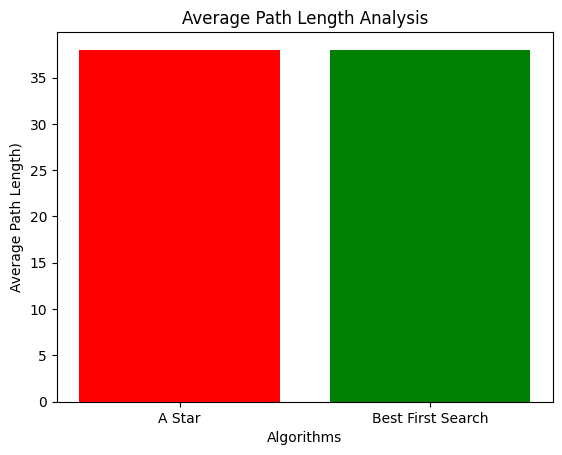

In [8]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt


# Combine all data into one list or array
all_path_lengths_A_star = [path_lengths_euclidean_A_star, path_lengths_manhattan_A_star, path_lengths_chebyshev_A_star, path_lengths_octile_A_star, path_lengths_zero_A_star]  # Add data for other heuristics
all_path_lengths_best_first = [path_lengths_euclidean_best_first, path_lengths_manhattan_best_first, path_lengths_chebyshev_best_first, path_lengths_octile_best_first, path_lengths_zero_best_first]  # Add data for other heuristics

average_of_two_games_A_star = []
average_of_two_games_best_first = []

for i in all_path_lengths_A_star:
    average = sum(i)/len(i)
    average_of_two_games_A_star.append(average)

for i in all_path_lengths_best_first:
    average = sum(i)/len(i)
    average_of_two_games_best_first.append(average)

a_star_path_lengths = sum(average_of_two_games_A_star) / len(average_of_two_games_A_star)
best_first_path_lengths = sum(average_of_two_games_best_first) / len(average_of_two_games_best_first)

path_lengthss = [a_star_path_lengths, best_first_path_lengths]

algorithm_list = ['A Star', 'Best First Search']
print("A star: "+str(a_star_path_lengths)+ " and Best-First: "+ str(best_first_path_lengths))
# Create a bar chart
plt.bar(algorithm_list, path_lengthss, color=['red', 'green'])
plt.xlabel('Algorithms')
plt.ylabel('Average Path Length)')
plt.title('Average Path Length Analysis')

# Display the plot
plt.show()

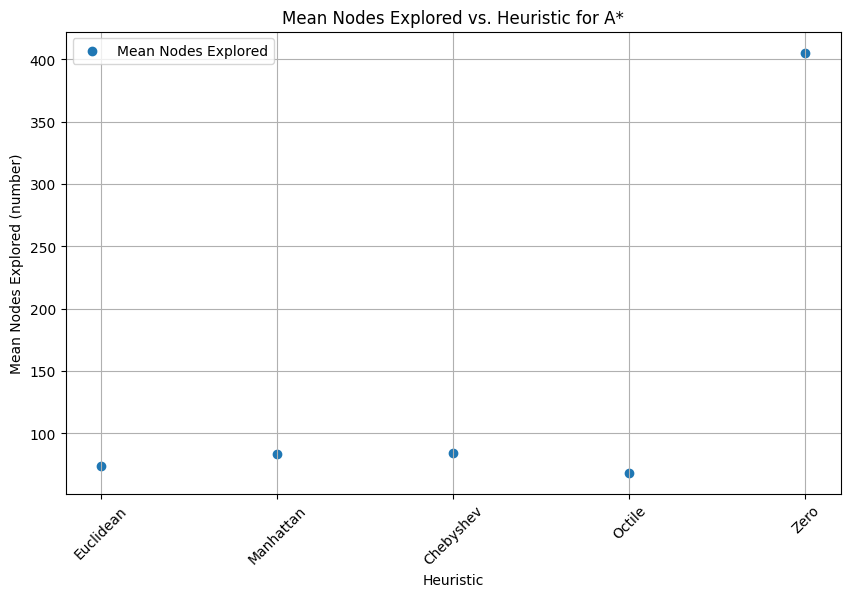

In [9]:
# Data
heuristics = ["Euclidean", "Manhattan", "Chebyshev", "Octile", "Zero"]
nodes_explored = [node_explored_euclidean_A_star, node_explored_manhattan_A_star, node_explored_chebyshev_A_star, node_explored_octile_A_star, node_explored_zero_A_star]

# Calculate the means for nodes explored
mean_nodes_explored = [sum(explored) / len(explored) for explored in nodes_explored]

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(heuristics, mean_nodes_explored, label="Mean Nodes Explored", marker="o")
plt.xlabel("Heuristic")
plt.ylabel("Mean Nodes Explored (number)")
plt.title("Mean Nodes Explored vs. Heuristic for A*")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

# Show the plot
plt.show()


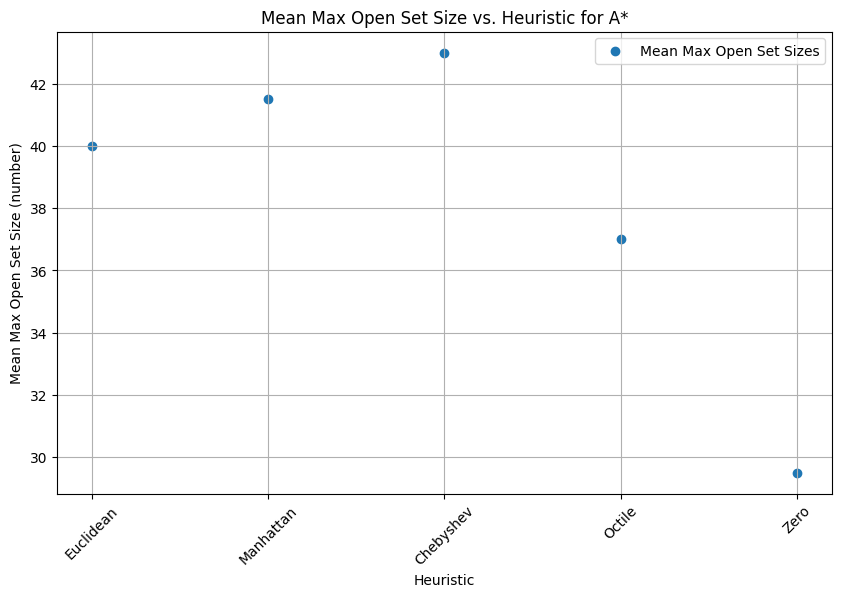

In [10]:
max_open_sizes = [open_sets_euclidean_A_star, open_sets_manhattan_A_star, open_sets_chebyshev_A_star, open_sets_octile_A_star, open_sets_zero_A_star]

# Calculate the means for nodes explored
mean_max_open_sizes = [sum(open_set) / len(open_set) for open_set in max_open_sizes]

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(heuristics, mean_max_open_sizes, label="Mean Max Open Set Sizes", marker="o")
plt.xlabel("Heuristic")
plt.ylabel("Mean Max Open Set Size (number)")
plt.title("Mean Max Open Set Size vs. Heuristic for A*")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

# Show the plot
plt.show()


[[61, 19], [65, 17], [51, 17], [51, 21], [61, 17]]


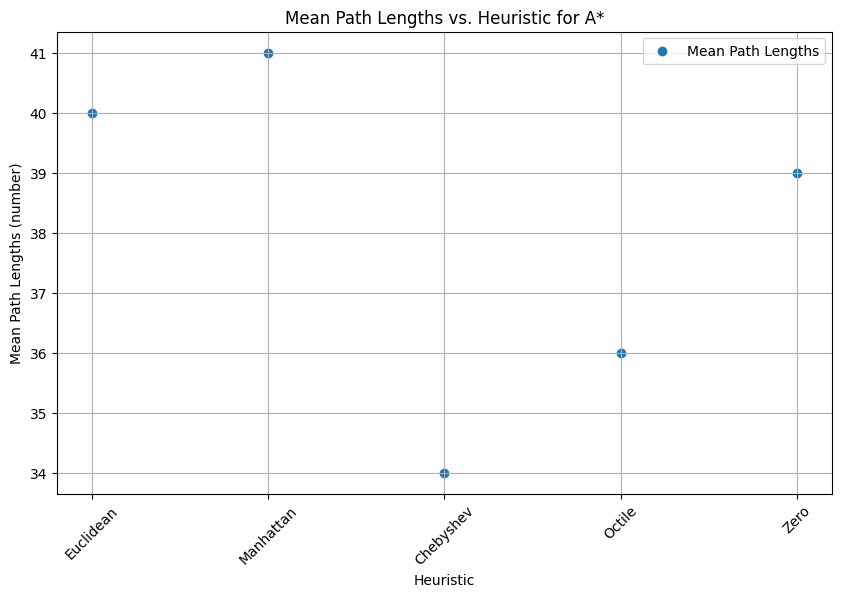

In [11]:
path_lengths = [path_lengths_euclidean_A_star, path_lengths_manhattan_A_star, path_lengths_chebyshev_A_star, path_lengths_octile_A_star, path_lengths_zero_A_star]
print(path_lengths)
# Calculate the means for nodes explored
mean_path_lengths = [sum(path_length) / len(path_length) for path_length in path_lengths]

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(heuristics, mean_path_lengths, label="Mean Path Lengths", marker="o")
plt.xlabel("Heuristic")
plt.ylabel("Mean Path Lengths (number)")
plt.title("Mean Path Lengths vs. Heuristic for A*")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

# Show the plot
plt.show()

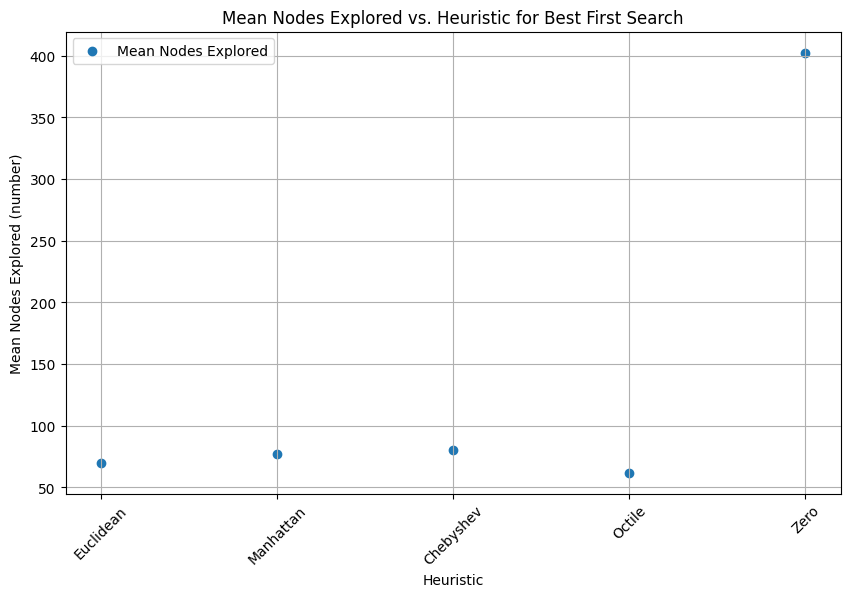

In [12]:
# Data
heuristics = ["Euclidean", "Manhattan", "Chebyshev", "Octile", "Zero"]
nodes_explored = [node_explored_euclidean_best_first, node_explored_manhattan_best_first, node_explored_chebyshev_best_first, node_explored_octile_best_first, node_explored_zero_best_first]

# Calculate the means for nodes explored
mean_nodes_explored = [sum(explored) / len(explored) for explored in nodes_explored]

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(heuristics, mean_nodes_explored, label="Mean Nodes Explored", marker="o")
plt.xlabel("Heuristic")
plt.ylabel("Mean Nodes Explored (number)")
plt.title("Mean Nodes Explored vs. Heuristic for Best First Search")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

# Show the plot
plt.show()


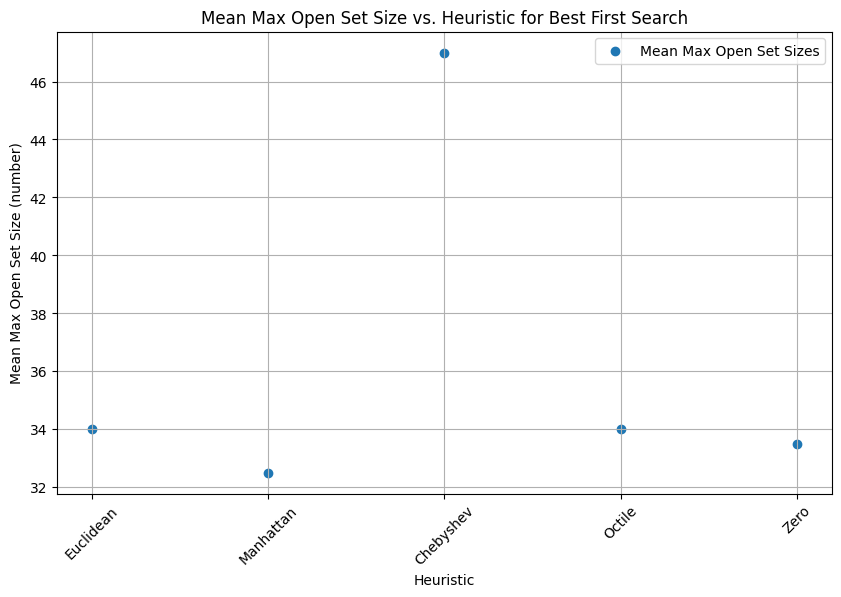

In [13]:
max_open_sizes = [open_sets_euclidean_best_first, open_sets_manhattan_best_first, open_sets_chebyshev_best_first, open_sets_octile_best_first, open_sets_zero_best_first]

# Calculate the means for nodes explored
mean_max_open_sizes = [sum(open_set) / len(open_set) for open_set in max_open_sizes]

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(heuristics, mean_max_open_sizes, label="Mean Max Open Set Sizes", marker="o")
plt.xlabel("Heuristic")
plt.ylabel("Mean Max Open Set Size (number)")
plt.title("Mean Max Open Set Size vs. Heuristic for Best First Search")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

# Show the plot
plt.show()


[[61, 17], [65, 17], [51, 17], [51, 21], [61, 17]]


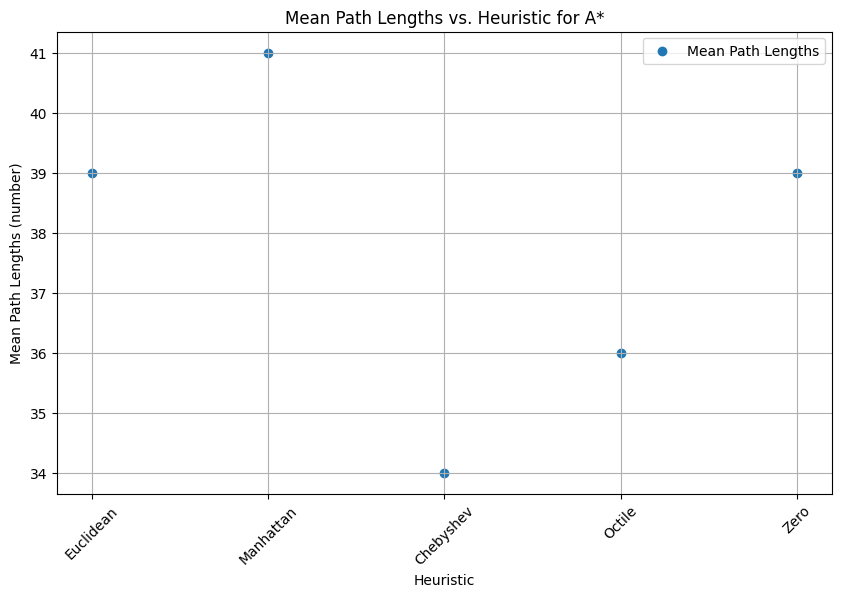

In [14]:
path_lengths = [path_lengths_euclidean_best_first, path_lengths_manhattan_A_star, path_lengths_chebyshev_A_star, path_lengths_octile_A_star, path_lengths_zero_A_star]
print(path_lengths)
# Calculate the means for nodes explored
mean_path_lengths = [sum(path_length) / len(path_length) for path_length in path_lengths]

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(heuristics, mean_path_lengths, label="Mean Path Lengths", marker="o")
plt.xlabel("Heuristic")
plt.ylabel("Mean Path Lengths (number)")
plt.title("Mean Path Lengths vs. Heuristic for A*")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

# Show the plot
plt.show()